# Informações gerais

Esse notebook objetiva comparar a performance de diferentes algoritmos de alocação e roteamento em comparação com o RSA e SAR.

Todas as simulações estão na Carga de 300 Erlangs

## Importando todos os pacotes e funções necessárias

In [1]:
# Printa a versão do Python
import sys
print(f"Versão do Python: {sys.version}")

Versão do Python: 3.11.7 (tags/v3.11.7:fa7a6f2, Dec  4 2023, 19:24:49) [MSC v.1937 64 bit (AMD64)]


In [2]:
# Importa as bibliotecas
import os
import pickle

import numpy as np
import pandas as pd

import torch as th

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

%matplotlib inline

In [3]:
from Enviroment.Settings import *
from Enviroment.Manager import Enviroment

In [4]:
from stable_baselines3 import PPO

In [5]:
def run_test(env, model, num_sim=10, main_seed=42):
    """ Realiza a simulação do modelo em um ambiente de simulação e retorna as probabilidades de bloqueio e as recompensas médias.

    Args:
        env (Enviroment): Ambiente de simulação.
        model (Model): Modelo a ser testado.
        num_sim (int): Número de simulações a serem realizadas.

    Returns:
        pbs (np.array): Probabilidades de bloqueio.
        reward (np.array): Recompensas médias.
    """

    number_of_nodes = env._number_of_nodes

    # Verifica se model é uma string com o nome do modelo
    if isinstance(model, str):
        if model not in ['RSA', 'SAR']:
            raise ValueError("Model must be 'RSA', 'SAR', a trained model from Stable Baselines 3 or a numpy array with the size equal to the number of nodes squared.")
    else:
        if not hasattr(model, 'predict') and not isinstance(model, np.ndarray) and model.shape != (number_of_nodes**2,):
            raise ValueError("Model must be 'RSA', 'SAR', a trained model from Stable Baselines 3 or a numpy array with the size equal to the number of nodes squared.")
    
    if isinstance(model, str):
        if model == 'RSA':
            print("Executando a avaliação do RSA")
        elif model == 'SAR':
            print("Executando a avaliação do SAR")
    elif isinstance(model, np.ndarray):
        print("Executando a avaliação do GA")
    else:
        print("Executando a avaliação do modelo")

    # Reseta a seed para garantir a reprodutibilidade dos resultados
    np.random.seed(main_seed)

    # Gera uma seed para cada simulação
    seeds = np.random.randint(0, 100_000, num_sim, dtype=int)

    # Cria um array para armazenar as probabilidades de bloqueio e as recompensas de cada simulação
    pbs = np.zeros(num_sim)
    rewards = np.zeros(num_sim)

    RSA_SAR_count = [0, 0]

    # Executa as simulações
    for i, seed in enumerate(seeds):

        print(f"Executando simulação {i+1} de {num_sim} com seed {seed}.")

        # Reseta o ambiente para garantir que ele esteja no estado inicial usando a seed
        state, info = env.reset(int(seed))

        # Executa a simulação
        while True:

            if isinstance(model, str):
                if model == 'RSA':
                    alg_heuristic = 0
                elif model == 'SAR':
                    alg_heuristic = 1
            elif isinstance(model, np.ndarray):
                alg_heuristic = model[state[1] + state[0] * 14]
            else:
                alg_heuristic = model.predict(observation=state, deterministic=True)[0]

            RSA_SAR_count[alg_heuristic] += 1

            state, _, done, trunk, info = env.step(alg_heuristic)

            if (done or trunk) and rewards[i] == 0:
                rewards[i] = env._reward_episode
                break

        pbs[i] = info['total_number_of_blocks'] / info['last_request']

        print(f"Blocking Probability: {pbs[i]} | Reward: {rewards[i]} | Req: {info['last_request']}")

    print(f"\nBlocking Probability: {np.mean(pbs)} | Min: {np.min(pbs)} | Max: {np.max(pbs)} | +- {np.std(pbs)}")
    print(f"Reward: {np.mean(rewards)} | Min: {np.min(rewards)} | Max: {np.max(rewards)} | +- {np.std(rewards)}")
    print(f"RSA count: {RSA_SAR_count[0]} ({RSA_SAR_count[0]/(RSA_SAR_count[0]+RSA_SAR_count[1]):.2%}) | SAR count: {RSA_SAR_count[1]} ({RSA_SAR_count[1]/(RSA_SAR_count[0]+RSA_SAR_count[1]):.2%})")

    return {
        'pbs': pbs,
        'rewards': rewards,
        'RSA_SAR_count': RSA_SAR_count
    }

# Avaliando os modelos

In [6]:
# Avaliando a PB do modelo treinado
enviroment_type = {
    "Observation": "ODD-one-hot",
    "Action": "Route",
    "Reward": "RL-defaut",
    "StopCond": "40kReqs",
    "StartCond": "Empty"
}

In [7]:
results_models_300e = {}

## Modelo RSA

In [8]:
# Cria o ambiente de simulação
env = Enviroment(
    network_load=300,
    k_routes=1,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type,
    data_folder="Evaluation_RSA_300e",
)

results_models_300e['RSA'] = run_test(env, 'RSA', num_sim=30, main_seed=123)

Executando a avaliação do RSA
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.037875 | Reward: 36970.0 | Req: 40000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.0396 | Reward: 36832.0 | Req: 40000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.039675 | Reward: 36826.0 | Req: 40000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.040375 | Reward: 36770.0 | Req: 40000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.036225 | Reward: 37102.0 | Req: 40000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.036675 | Reward: 37066.0 | Req: 40000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.03785 | Reward: 36972.0 | Req: 40000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.032075 | Reward: 37434.0 | Req: 40000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.0401 | Reward: 36792.0 | Req: 40000
Executando s

# Comparando os modelos

In [9]:
def include_models(models_results):
    
    # Cria um boxplot com as probabilidades de bloqueio no gráfico da esquerda e um boxplot com as recompensas no gráfico da direita para cada modelo
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Cria a lista com o nome dos modelos
    data_name = []
    # Cria a lista com as probabilidades de bloqueio
    data_PB = []
    # Cria a lista com as recompensas
    data_rewards = []

    data_RSA_SAR_count = []

    for model_name, model_data in models_results.items():

        data_name.append(model_name)

        data_PB.append(model_data["pbs"])

        data_rewards.append(model_data["rewards"])

        data_RSA_SAR_count.append(model_data["RSA_SAR_count"])

    # Boxplot das probabilidades de bloqueio em escala logarítmica
    sns.boxplot(data=data_PB, ax=axs[0])
    axs[0].set_yscale("log")

    axs[0].set_title("Blocking Probability")

    axs[0].xaxis.set_major_locator(ticker.FixedLocator(range(len(data_name))))  # Set fixed locations for ticks
    axs[0].set_xticklabels(data_name)

    axs[0].set_ylabel("Blocking Probability")
    axs[0].grid(axis="y", which="both", linestyle="--", linewidth=0.7)


    sns.boxplot(data=data_rewards, ax=axs[1])

    axs[1].set_title("Rewards")

    axs[1].xaxis.set_major_locator(ticker.FixedLocator(range(len(data_name))))  # Set fixed locations for ticks
    axs[1].set_xticklabels(data_name)
    axs[1].set_ylabel("Rewards")

    axs[1].grid(axis="y", which="both", linestyle="--", linewidth=0.7)

    # Gráfico com a contagem de RSA e SAR
    data_RSA_SAR_count = np.array(data_RSA_SAR_count)

    axs[2].bar(data_name, data_RSA_SAR_count[:, 0], label="RSA")
    axs[2].bar(data_name, data_RSA_SAR_count[:, 1], bottom=data_RSA_SAR_count[:, 0], label="SAR")

    axs[2].set_title("RSA and SAR count")

    axs[2].set_ylabel("Count")
    axs[2].legend()
    axs[2].grid(axis="y", which="both", linestyle="--", linewidth=0.7)

    


    # Se há mais que 4 modelos a serem comparados, rotaciona os labels do eixo x
    if len(data_name) > 4:
        for ax in axs:
            ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')

    plt.show()

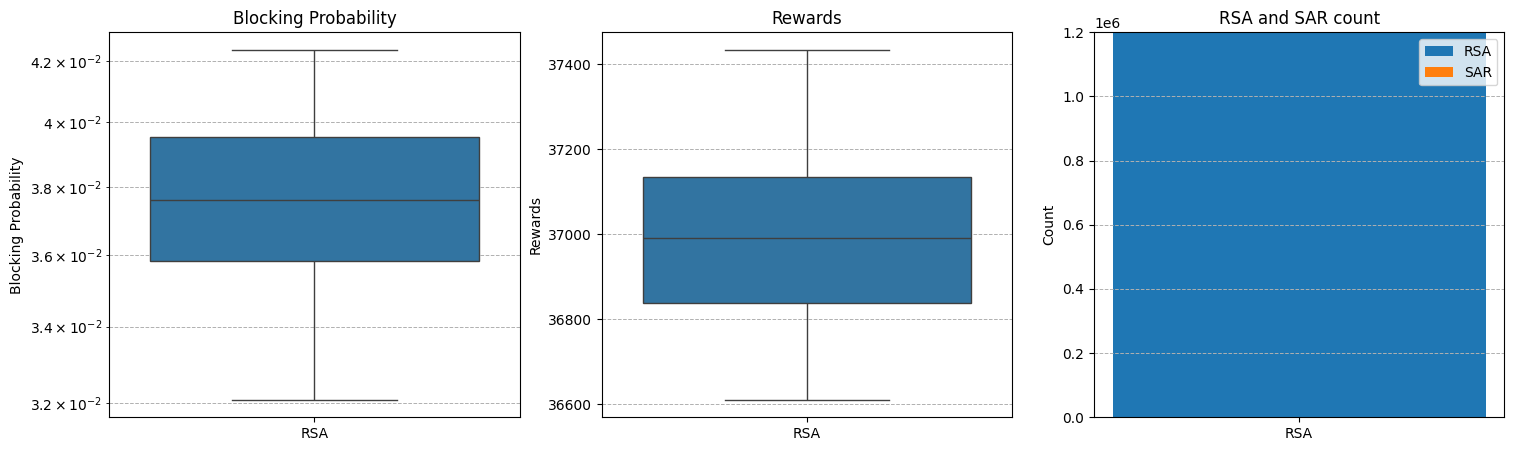

In [10]:
include_models(results_models_300e)

# Testando modelos com diferentes configurações

### Modelo v18

Utilizando ODD-one-hot

In [11]:
# Cria o ambiente de simulação
env = Enviroment(
    network_load=300,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type,
    data_folder="PPO_Eval",
)

model_018 = PPO.load("D:\\98_phD_Files\\Projeto 006 - Artigo rede regular iTwo\\logs\\Train_PPO_40kReqs_300_v18_009\\training\\best_model\\best_model.zip", env=env)

## Retorna a PB para o modelo treinado
results_models_300e['Route V18'] = run_test(env, model_018, num_sim=30, main_seed=123)

Executando a avaliação do modelo
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.037875 | Reward: 36970.0 | Req: 40000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.0396 | Reward: 36832.0 | Req: 40000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.039675 | Reward: 36826.0 | Req: 40000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.040375 | Reward: 36770.0 | Req: 40000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.036225 | Reward: 37102.0 | Req: 40000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.036675 | Reward: 37066.0 | Req: 40000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.03785 | Reward: 36972.0 | Req: 40000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.032075 | Reward: 37434.0 | Req: 40000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.0401 | Reward: 36792.0 | Req: 40000
Executand

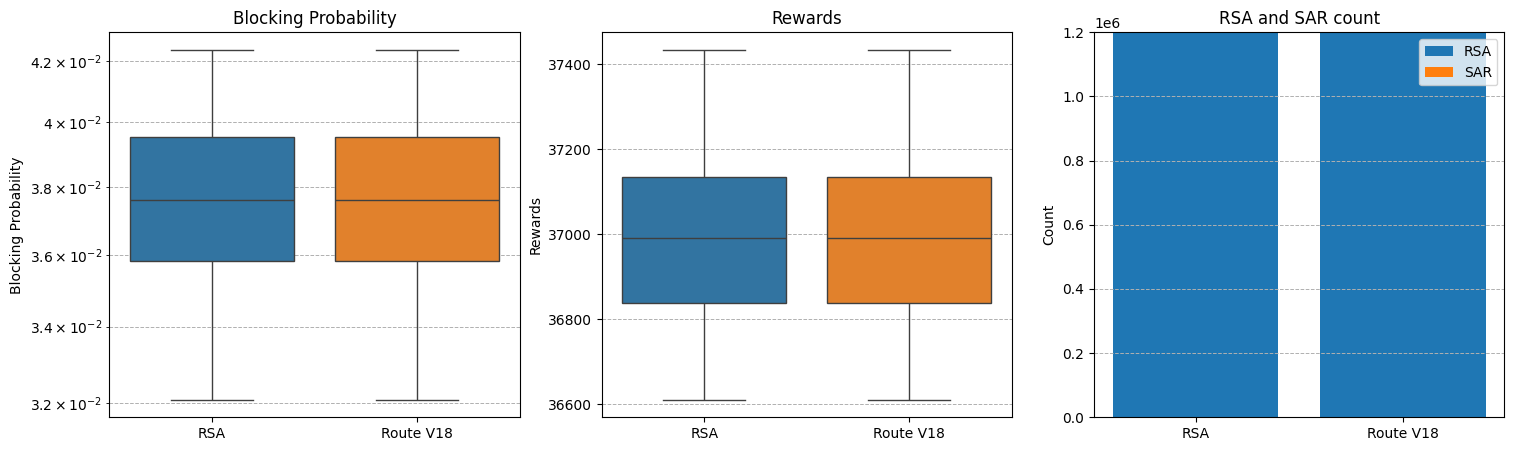

In [12]:
include_models(results_models_300e)